# Homework 3 - Berkeley STAT 157

Handout 2/5/2019, due 2/12/2019 by 4pm in Git by committing to your repository.

**Formatting: please include both a .ipynb and .pdf file in your homework submission, named homework3.ipynb and homework3.pdf. You can export your notebook to a pdf either by File -> Download as -> PDF via Latex (you may need Latex installed), or by simply printing to a pdf from your browser (you may want to do File -> Print Preview in jupyter first). Please don't change the filename.**       

In [8]:
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
import numpy as np
from mxnet.gluon import nn
from mxnet.gluon import loss as gloss
from mxnet.gluon import data as gdata
from mxnet import init

# 1. Logistic Regression for Binary Classification

In multiclass classification we typically use the exponential model 

$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

1.1. Show that this parametrization has a spurious degree of freedom. That is, show that both $\mathbf{o}$ and $\mathbf{o} + c$ with $c \in \mathbb{R}$ lead to the same probability estimate.

#### Ans 1.1)  
We can see that
$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})} \\ \ \ \\ p(y|\mathbf{o+c}) = \mathrm{softmax}(\mathbf{o+c})_y = \frac{\exp(o_y+c)}{\sum_{y'} \exp(o_{y'}+c)} \ = \frac{\\exp(c)\exp(o_y)}{\exp(c)\sum_{y'} \exp(o_{y'})} \ = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$



1.2. For binary classification, i.e. whenever we have only two classes $\{-1, 1\}$, we can arbitrarily set $o_{-1} = 0$. Using the shorthand $o = o_1$ show that this is equivalent to 

$$p(y=1|o) = \frac{1}{1 + \exp(-o)}$$

#### Ans 1.2)

Since $$p(y=1|o) = \frac{\exp(o)}{\exp(0) + \exp(o)} = \frac{\exp(o)}{1 + \exp(o)} =\frac{\frac{\exp(o)}{\exp(o)}}{\frac{1}{\exp(o)} + \frac{\exp(o)}{\exp(o)}} = \frac{1}{1+\exp(-o)}$$

1.3. Show that the log-likelihood loss (often called logistic loss) for labels $y \in \{-1, 1\}$ is thus given by 

$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$

#### Ans 1.3)

Since the two probabilities only differ by the sign of the exponent in the denominator and using the results from previous parts, $$p(y=1|o) = \frac{1}{1 + \exp(-o)} \ $$ and by Kolmogorov's second axiom, probabilities sum up to 1,  $$\ p(y=-1|o) = \frac{\exp(-o)}{1 + \exp(-o)} = \frac{\exp(-o) \cdot \exp(o)}{1 \cdot \exp(o) + \exp(-o) \cdot \exp(o)}  = \frac{1}{1 + \exp(o)} \ $$ we can combine this into a single equation and manipulate to arrive at the given result $$ p(y|o) = \frac{1}{1 + \exp(-y \cdot o)} \\\ \log p(y|o) = -\log(1 + \exp(-y \cdot o)) \\ -\log p(y|o) = \log(1 + \exp(-y \cdot o))$$

1.4. Show that for $y = 1$ the logistic loss asymptotes to $o$ for $o \to \infty$ and to $\exp(o)$ for $o \to -\infty$. 

#### Ans 1.4)

By above, $$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$
$$-\log p(y=1|o) = \log (1 + \exp(-o))$$
and for $$o \to \infty, \exp(-o) \to 0$$

# 2. Logistic Regression and Autograd

1. Implement the binary logistic loss $l(y,o) = \log (1 + \exp(-y \cdot o))$ in Gluon

In [46]:
def loss(y,o):
    ## add your loss function here
    return nd.log(1+nd.exp(-y*o))

In [47]:
def vloss(y,o):
    ## Vectorized loss
    return nd.log(1+nd.exp(-y*o))

2.1. Plot its values for $y \in \{-1, 1\}$ over the range of $o \in [-5, 5]$.

#### Ans 2.1)

In [73]:
o = nd.arange(-5, 6)
o_cop = nd.arange(-5, 6)
y_neg = nd.zeros(len(o))
y_pos = nd.zeros(len(o))
neg_loss = vloss(-1, o)
pos_loss = vloss(1, o)

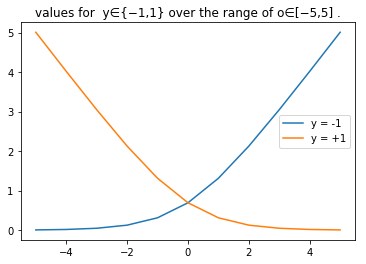

In [74]:
plt.figure()
plt.plot(o.asnumpy(), neg_loss.asnumpy(),label = 'y = -1')
plt.plot(o.asnumpy(), pos_loss.asnumpy(), label = 'y = +1')
plt.title("values for  y∈{−1,1} over the range of o∈[−5,5] .")
plt.legend()
plt.show()

2.2. Plot its derivative with respect to $o$ for $o \in [-5, 5]$ using 'autograd'.

#### Ans 2.2)

In [75]:
o.attach_grad()
o_cop.attach_grad()
with autograd.record():
    neg_loss = vloss(-1, o)
    pos_loss = vloss(1, o_cop)
neg_loss.backward()
pos_loss.backward() 

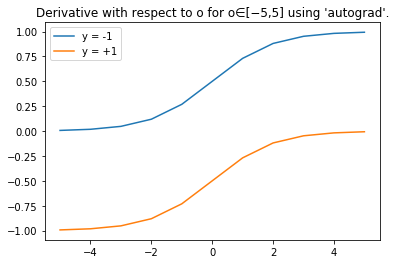

In [79]:
plt.figure()
plt.plot(o.asnumpy(), o.grad.asnumpy(),label = 'y = -1')
plt.plot(o.asnumpy(), o_cop.grad.asnumpy(), label = 'y = +1')
plt.title("Derivative with respect to o for o∈[−5,5] using 'autograd'.")
plt.legend()
plt.show()

# 3. Ohm's Law

Imagine that you're a young physicist, maybe named [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm), trying to figure out how current and voltage depend on each other for resistors. You have some idea but you aren't quite sure yet whether the dependence is linear or quadratic. So you take some measurements, conveniently given to you as 'ndarrays' in Python. They are indicated by 'current' and 'voltage'.

Your goal is to use least mean squares regression to identify the coefficients for the following three models using automatic differentiation and least mean squares regression. The three models are:

1. Quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.
1. Linear model where $\mathrm{voltage} = c + r \cdot \mathrm{current}$.
1. Ohm's law where $\mathrm{voltage} = r \cdot \mathrm{current}$.

In [122]:
current = nd.array([1.5420291, 1.8935232, 2.1603365, 2.5381863, 2.893443, \
                    3.838855, 3.925425, 4.2233696, 4.235571, 4.273397, \
                    4.9332876, 6.4704757, 6.517571, 6.87826, 7.0009003, \
                    7.035741, 7.278681, 7.7561755, 9.121138, 9.728281])
voltage = nd.array([63.802246, 80.036026, 91.4903, 108.28776, 122.781975, \
                    161.36314, 166.50816, 176.16772, 180.29395, 179.09758, \
                    206.21027, 272.71857, 272.24033, 289.54745, 293.8488, \
                    295.2281, 306.62274, 327.93243, 383.16296, 408.65967])

In [123]:
# L2 loss function and parameters
loss = gloss.L2Loss() 
batch_size = 20 
num_epochs = 20

#### Work 3.1). Quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.


In [163]:
quad_current = np.vstack((current.asnumpy(), current.asnumpy()**2))
quad_current = nd.array(quad_current.T)
quad_data = gdata.ArrayDataset(quad_current, voltage)
quad_data_iter = gdata.DataLoader(quad_data, batch_size, shuffle=True)

# Define the Model
quad_model = nn.Sequential() 
quad_model.add(nn.Dense(1, use_bias=True))

# Initialize Model Parameters
quad_model.initialize(init.Normal(sigma=0.01))

# Define the Optimization Algorithm
quad_trainer = gluon.Trainer(quad_model.collect_params(), 'sgd', {'learning_rate': 0.001})

# Training:
print("Using the Quadratic model where  voltage = c + r⋅current + q⋅current^22")
for epoch in range(1, num_epochs + 1): 
    for X, y in quad_data_iter:
        with autograd.record():
            l = loss(quad_model(X), y)
        l.backward()
        quad_trainer.step(batch_size)
    l = loss(quad_model(quad_current), voltage)
    print("epoch {}, loss: {}".format(epoch, l.mean().asscalar()))

Using the Quadratic model where  voltage = c + r⋅current + q⋅current^22
epoch 1, loss: 18725.42578125
epoch 2, loss: 12350.0771484375
epoch 3, loss: 8394.375
epoch 4, loss: 5938.53369140625
epoch 5, loss: 4412.4091796875
epoch 6, loss: 3462.59521484375
epoch 7, loss: 2870.032958984375
epoch 8, loss: 2498.93603515625
epoch 9, loss: 2265.134033203125
epoch 10, loss: 2116.456787109375
epoch 11, loss: 2020.5640869140625
epoch 12, loss: 1957.409423828125
epoch 13, loss: 1914.567138671875
epoch 14, loss: 1884.3353271484375
epoch 15, loss: 1861.939208984375
epoch 16, loss: 1844.420166015625
epoch 17, loss: 1829.9423828125
epoch 18, loss: 1817.369140625
epoch 19, loss: 1805.9951171875
epoch 20, loss: 1795.3831787109375


In [194]:
quad_params_iter = quad_model.collect_params('.*weight|.*bias')
for i in quad_params_iter:
    print(i, quad_params_iter[str(i)].data())

dense18_bias 
[0.8241394]
<NDArray 1 @cpu(0)>
dense18_weight 
[[2.5383394 5.146415 ]]
<NDArray 1x2 @cpu(0)>


#### Ans 3.1). Quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.


For quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.
$$c = 0.8241394$$
$$r = 2.5383394$$
$$q = 5.146415$$

#### Work 3.2). Linear model where $\mathrm{voltage} = c + r \cdot \mathrm{current}$.

In [229]:
linear_data = gdata.ArrayDataset(current, voltage)
linear_data_iter = gdata.DataLoader(linear_data, batch_size, shuffle=True)

# Define the Model
linear_model = nn.Sequential() 
linear_model.add(nn.Dense(1, use_bias=True))

# Initialize Model Parameters
from mxnet import init
linear_model.initialize(init.Normal(sigma=0.01))

# Define the Optimization Algorithm
linear_trainer = gluon.Trainer(linear_model.collect_params(), 'sgd', {'learning_rate': 0.05})

# Training:
print("Using the Linear model where  voltage = c + r⋅current")
for epoch in range(1, num_epochs + 1): 
    for X, y in linear_data_iter:
        with autograd.record():
            l = loss(linear_model(X), y)
        l.backward()
        linear_trainer.step(batch_size)
    l = loss(linear_model(current), voltage)
    print("epoch {}, loss: {}".format(epoch, l.mean().asscalar()))

Using the Linear model where  voltage = c + r⋅current
epoch 1, loss: 13387.701171875
epoch 2, loss: 6182.4619140625
epoch 3, loss: 2856.069580078125
epoch 4, loss: 1320.3841552734375
epoch 5, loss: 611.3969116210938
epoch 6, loss: 284.06121826171875
epoch 7, loss: 132.91917419433594
epoch 8, loss: 63.11895751953125
epoch 9, loss: 30.871089935302734
epoch 10, loss: 15.960115432739258
epoch 11, loss: 9.053342819213867
epoch 12, loss: 5.842033386230469
epoch 13, loss: 4.337221622467041
epoch 14, loss: 3.620575428009033
epoch 15, loss: 3.268150806427002
epoch 16, loss: 3.0842342376708984
epoch 17, loss: 2.978449821472168
epoch 18, loss: 2.909083843231201
epoch 19, loss: 2.8568716049194336
epoch 20, loss: 2.8129324913024902


In [230]:
linear_params_iter = linear_model.collect_params('.*weight|.*bias')
for i in linear_params_iter:
    print(i, linear_params_iter[str(i)].data())

dense45_bias 
[5.631054]
<NDArray 1 @cpu(0)>
dense45_weight 
[[41.138016]]
<NDArray 1x1 @cpu(0)>


#### Ans 3.2). Quadratic model where  $\mathrm{voltage} = c + r \cdot \mathrm{current}$.


For linear model where $\mathrm{voltage} = c + r \cdot \mathrm{current}$.
$$c = 5.6292043$$
$$r = 41.138317$$


#### Work 3.3). Ohm's law where $\mathrm{voltage} = r \cdot \mathrm{current}$.

In [231]:
ohm_data = gdata.ArrayDataset(current, voltage)
ohm_data_iter = gdata.DataLoader(ohm_data, batch_size, shuffle=True)

# Define the Model
ohm_model = nn.Sequential() 
ohm_model.add(nn.Dense(1, use_bias=False))

# Initialize Model Parameters
from mxnet import init
ohm_model.initialize(init.Normal(sigma=0.01))

# Define the Optimization Algorithm
ohm_trainer = gluon.Trainer(ohm_model.collect_params(), 'sgd', {'learning_rate': 0.01})

# Training:
print("Using the Ohm's Law model where  voltage = r⋅current")
for epoch in range(1, num_epochs + 1): 
    for X, y in ohm_data_iter:
        with autograd.record():
            l = loss(ohm_model(X), y)
        l.backward()
        ohm_trainer.step(batch_size)
    l = loss(ohm_model(current), voltage)
    print("epoch {}, loss: {}".format(epoch, l.mean().asscalar()))

Using the Ohm's Law model where  voltage = r⋅current
epoch 1, loss: 13104.103515625
epoch 2, loss: 5925.7841796875
epoch 3, loss: 2679.8720703125
epoch 4, loss: 1212.1263427734375
epoch 5, loss: 548.4365234375
epoch 6, loss: 248.3280029296875
epoch 7, loss: 112.6241455078125
epoch 8, loss: 51.26112747192383
epoch 9, loss: 23.513864517211914
epoch 10, loss: 10.966987609863281
epoch 11, loss: 5.293465614318848
epoch 12, loss: 2.7279913425445557
epoch 13, loss: 1.567939043045044
epoch 14, loss: 1.0433976650238037
epoch 15, loss: 0.8062097430229187
epoch 16, loss: 0.6989573836326599
epoch 17, loss: 0.6504567861557007
epoch 18, loss: 0.6285218596458435
epoch 19, loss: 0.618601381778717
epoch 20, loss: 0.6141220331192017


In [232]:
ohm_params_iter = ohm_model.collect_params('.*weight|.*bias')
for i in ohm_params_iter:
    print(i, ohm_params_iter[str(i)].data())

dense46_weight 
[[42.041676]]
<NDArray 1x1 @cpu(0)>


#### Ans 3.3). Quadratic model where  $\mathrm{voltage} = r \cdot \mathrm{current}$.


For linear model where $\mathrm{voltage} = r \cdot \mathrm{current}$.
$$r = 42.041676$$


# 4. Entropy

Let's compute the *binary* entropy of a number of interesting data sources. 

1. Assume that you're watching the output generated by a [monkey at a typewriter](https://en.wikipedia.org/wiki/File:Chimpanzee_seated_at_typewriter.jpg). The monkey presses any of the $44$ keys of the typewriter at random (you can assume that it has not discovered any special keys or the shift key yet). How many bits of randomness per character do you observe?
1. Unhappy with the monkey you replaced it by a drunk typesetter. It is able to generate words, albeit not coherently. Instead, it picks a random word out of a vocabulary of $2,000$ words. Moreover, assume that the average length of a word is $4.5$ letters in English. How many bits of randomness do you observe now?
1. Still unhappy with the result you replace the typesetter by a high quality language model. These can obtain perplexity numbers as low as 20 points per character. The perplexity is defined as a length normalized probability, i.e.

$$\mathrm{PPL}(x) = \left[p(x)\right]^{1/\mathrm{length}(x)}$$

In [4]:
def entro(p):
    ret = 0
    for i in p:
        ret += i * np.log2(i)
    return -ret

#### Ans 4.1) 

In [5]:
monkey_dist = np.ones(44)/44
print("We observe",entro(monkey_dist), "bits of randomness")

We observe 5.4594316186372955 bits of randomness


#### Ans 4.2)

In [6]:
drunk = np.ones(2000)/2000
print("We observe",entro(drunk)*np.log2(4.5), "bits of randomness")

We observe 23.794929479711104 bits of randomness


#### Ans 4.3)

# 5. Wien's Approximation for the Temperature (bonus)

We will now abuse Gluon to estimate the temperature of a black body. The energy emanated from a black body is given by Wien's approximation.

$$B_\lambda(T) = \frac{2 h c^2}{\lambda^5} \exp\left(-\frac{h c}{\lambda k T}\right)$$

That is, the amount of energy depends on the fifth power of the wavelength $\lambda$ and the temperature $T$ of the body. The latter ensures a cutoff beyond a temperature-characteristic peak. Let us define this and plot it.

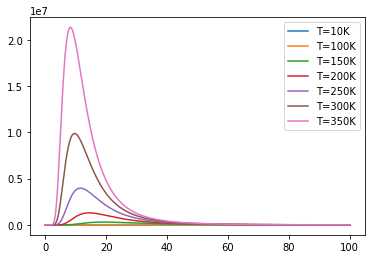

In [48]:
# Lightspeed
c = 299792458
# Planck's constant
h = 6.62607004e-34
# Boltzmann constant
k = 1.38064852e-23
# Wavelength scale (nanometers)
lamscale = 1e-6
# Pulling out all powers of 10 upfront
p_out = 2 * h * c**2 / lamscale**5
p_in = (h / k) * (c/lamscale) 

# Wien's law
def wien(lam, t):
    return (p_out / lam**5) * nd.exp(-p_in / (lam * t))

# Plot the radiance for a few different temperatures
lam = nd.arange(0,100,0.01)
for t in [10, 100, 150, 200, 250, 300, 350]:
    radiance = wien(lam, t)
    plt.plot(lam.asnumpy(), radiance.asnumpy(), label=('T=' + str(t) + 'K'))
plt.legend()
plt.show()

Next we assume that we are a fearless physicist measuring some data. Of course, we need to pretend that we don't really know the temperature. But we measure the radiation at a few wavelengths.  

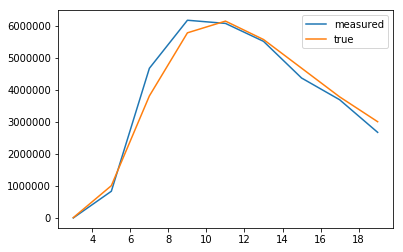

In [49]:
# real temperature is approximately 0C
realtemp = 273
# we observe at 3000nm up to 20,000nm wavelength
wavelengths = nd.arange(3,20,2)
# our infrared filters are pretty lousy ...
delta = nd.random_normal(shape=(len(wavelengths))) * 1

radiance = wien(wavelengths + delta,realtemp)
plt.plot(wavelengths.asnumpy(), radiance.asnumpy(), label='measured')
plt.plot(wavelengths.asnumpy(), wien(wavelengths, realtemp).asnumpy(), label='true')
plt.legend()
plt.show()

Use Gluon to estimate the real temperature based on the variables `wavelengths` and `radiance`. 

* You can use Wien's law implementation `wien(lam,t)` as your forward model. 
* Use the loss function $l(y,y') = (\log y - \log y')^2$ to measure accuracy.

In [50]:
loss = lambda y, y_: nd.power((nd.log(y) - nd.log(y_)),2)

In [53]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'))
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))

In [56]:
for X, y in data_iter:
    print(X)
    print(y)


[ 5. 15.  9. 17. 19.  3.  7. 11. 13.]
<NDArray 9 @cpu(0)>

[8.3406569e+05 4.3657910e+06 6.1674050e+06 3.6885735e+06 2.6709998e+06
 2.5073965e+03 4.6691925e+06 6.0690080e+06 5.5093220e+06]
<NDArray 9 @cpu(0)>


In [55]:
batch_size = 256


# Combine the features and labels of the training data
dataset = gdata.ArrayDataset(wavelengths, radiance)
# Randomly reading mini-batches
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
num_epochs = 10


# Training
for epoch in range(1, num_epochs + 1):
    for wave, rad in data_iter:
        with autograd.record():
            forward = wien(X,y)
            l = loss(y, forward)
        l.backward()
        trainer.step(batch_size)
    train_l = loss(net(features), labels)
    print('epoch %d, loss: %f' % (epoch, train_l.mean().asnumpy()))

MXNetError: [13:23:04] src/imperative/imperative.cc:285: Check failed: !AGInfo::IsNone(*i) Cannot differentiate node because it is not in a computational graph. You need to set is_recording to true or use autograd.record() to save computational graphs for backward. If you want to differentiate the same graph twice, you need to pass retain_graph=True to backward.

Stack trace returned 6 entries:
[bt] (0) 0   libmxnet.so                         0x000000010d53ab90 libmxnet.so + 15248
[bt] (1) 1   libmxnet.so                         0x000000010d53a93f libmxnet.so + 14655
[bt] (2) 2   libmxnet.so                         0x000000010ea8d0e9 MXNDListFree + 550809
[bt] (3) 3   libmxnet.so                         0x000000010e9dff2e MXAutogradBackwardEx + 1022
[bt] (4) 4   _ctypes.so                          0x0000000105b4d127 ffi_call_unix64 + 79
[bt] (5) 5   python                              0x00007fff5bffc310 __progname + 140730441904752

